<a href="https://colab.research.google.com/github/max-grahum/Kauricone/blob/main/SectionGrass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# @title Insert image path here
image_path = "7am-image1.jpg" # @param {type:"string"}

In [12]:
# @title Would you like to zip all your contents?
is_zip_contents = False # @param {type:"boolean"}
if (is_zip_contents):
  !zip -r output.zip output
# change sample_data.zip to your desired download name Ex: nothing.zip
# change sample_data to your desired download folder name Ex: ner_data

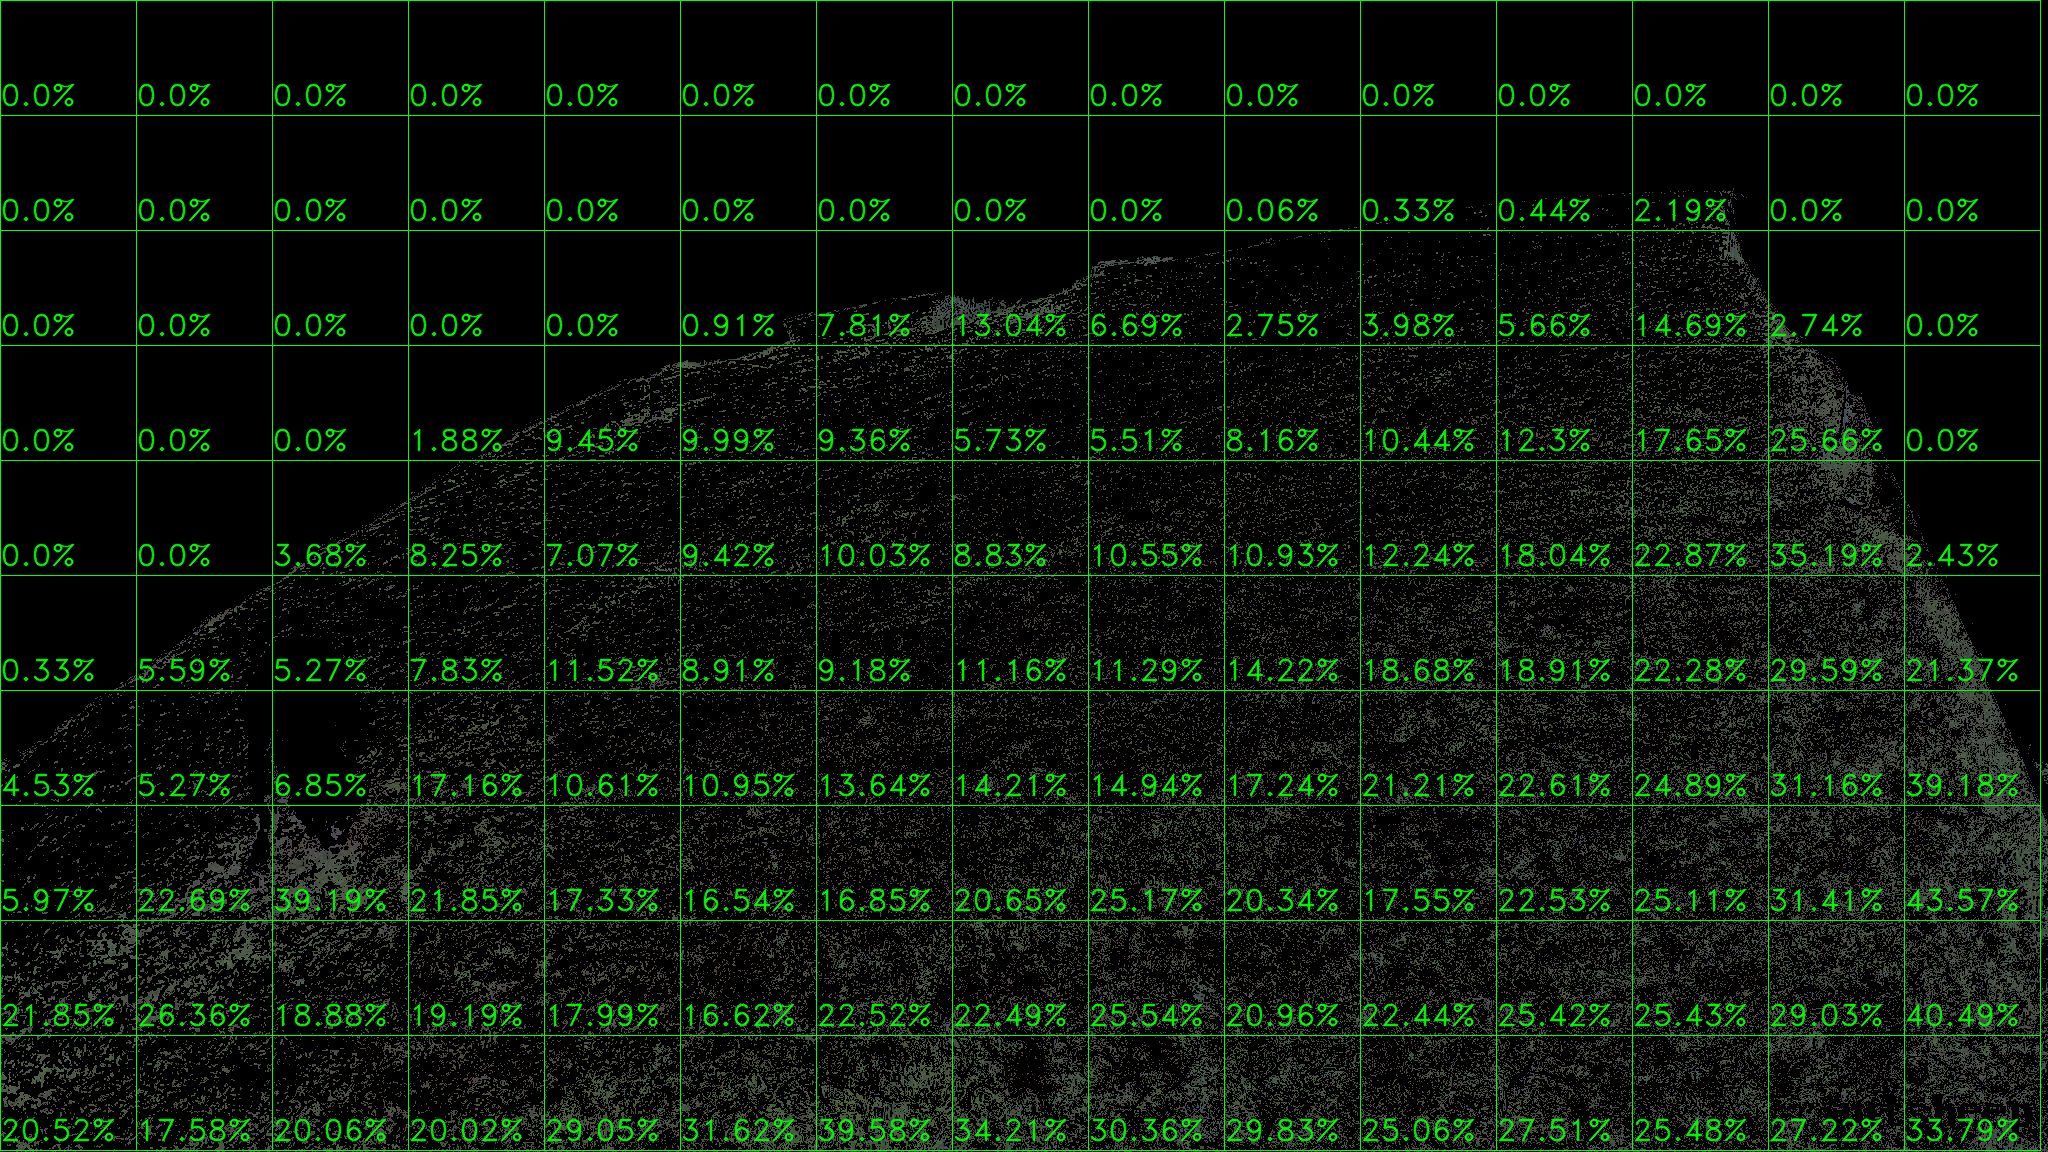

Total percentage of healthy grass colors: 12.68%


In [13]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

# Create diretory
dirname = 'output'
os.mkdir(dirname)

# Load the image
image_file_name = image_path.split('.')[0]
image = cv2.imread(image_path)

# Resize the image to a smaller size for faster processing
scale_percent = 100  # You can adjust this percentage
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
image = cv2.resize(image, (width, height))

# Flatten the image into a 2D array of pixels
pixels = image.reshape(-1, 3)

# Defined range for typical grass colours
lower_grass = np.array([52, 64, 47])
upper_grass = np.array([100, 115, 85])

# Define the number of rows and columns for segmentation
n_rows = 10  # Adjust as needed
n_cols = 15  # Adjust as needed

# Calculate the size of each section
section_height = height // n_rows
section_width = width // n_cols

# Array of grass percentages
grass_percentage = []

# Mask whole image
whole_mask = cv2.inRange(image, lower_grass, upper_grass)
green_image = cv2.bitwise_and(image, image, mask=whole_mask)

# Iterate through the sections
for row in range(n_rows):
    for col in range(n_cols):
        # Define the coordinates of the section
        x1 = col * section_width
        y1 = row * section_height
        x2 = (col + 1) * section_width
        y2 = (row + 1) * section_height

        # Crop the section from the original image
        section = image[y1:y2, x1:x2]

        # Flatten the section into a 2D array of pixels
        section_pixels = section.reshape(-1, 3)

        # Count the number of pixels classified as grass colors (cluster 0)
        mask = cv2.inRange(section, lower_grass, upper_grass)

        # Count the number of pixels within the color range
        grass_pixel_count = np.count_nonzero(mask)

        # Calculate the percentage of grass colors in the section
        total_pixels = section_pixels.shape[0]
        percentage = (grass_pixel_count / total_pixels) * 100
        grass_percentage.append(percentage)
        percent_str = str(round(percentage,2))+'%'

        # Draw borders around sections
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0))
        cv2.putText(image, percent_str, (x1,y2-10), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 0), 1, cv2.LINE_AA)
        cv2.imwrite("save/" + str(x1) + '_' + str(y1)+".png", section)

        # Do the same but with new mask
        cv2.rectangle(green_image, (x1, y1), (x2, y2), (0, 255, 0))
        cv2.putText(green_image, percent_str, (x1,y2-10), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 0), 1, cv2.LINE_AA)
        cv2.imwrite("save/" + str(x2) + '_' + str(y2)+".png", section)

# Print or use the grass_percentage values as needed

cv2.imwrite("output/"+image_file_name+"-image-percent.png",image)
cv2.imwrite("output/"+image_file_name+"-green-pixels.png",green_image)

cv2_imshow(green_image) # Display green pixels

# Calculate total percentage of green grass detected
percent_avg = sum(grass_percentage) / len(grass_percentage)
print(f"Total percentage of healthy grass colors: {round(percent_avg,2)}%")

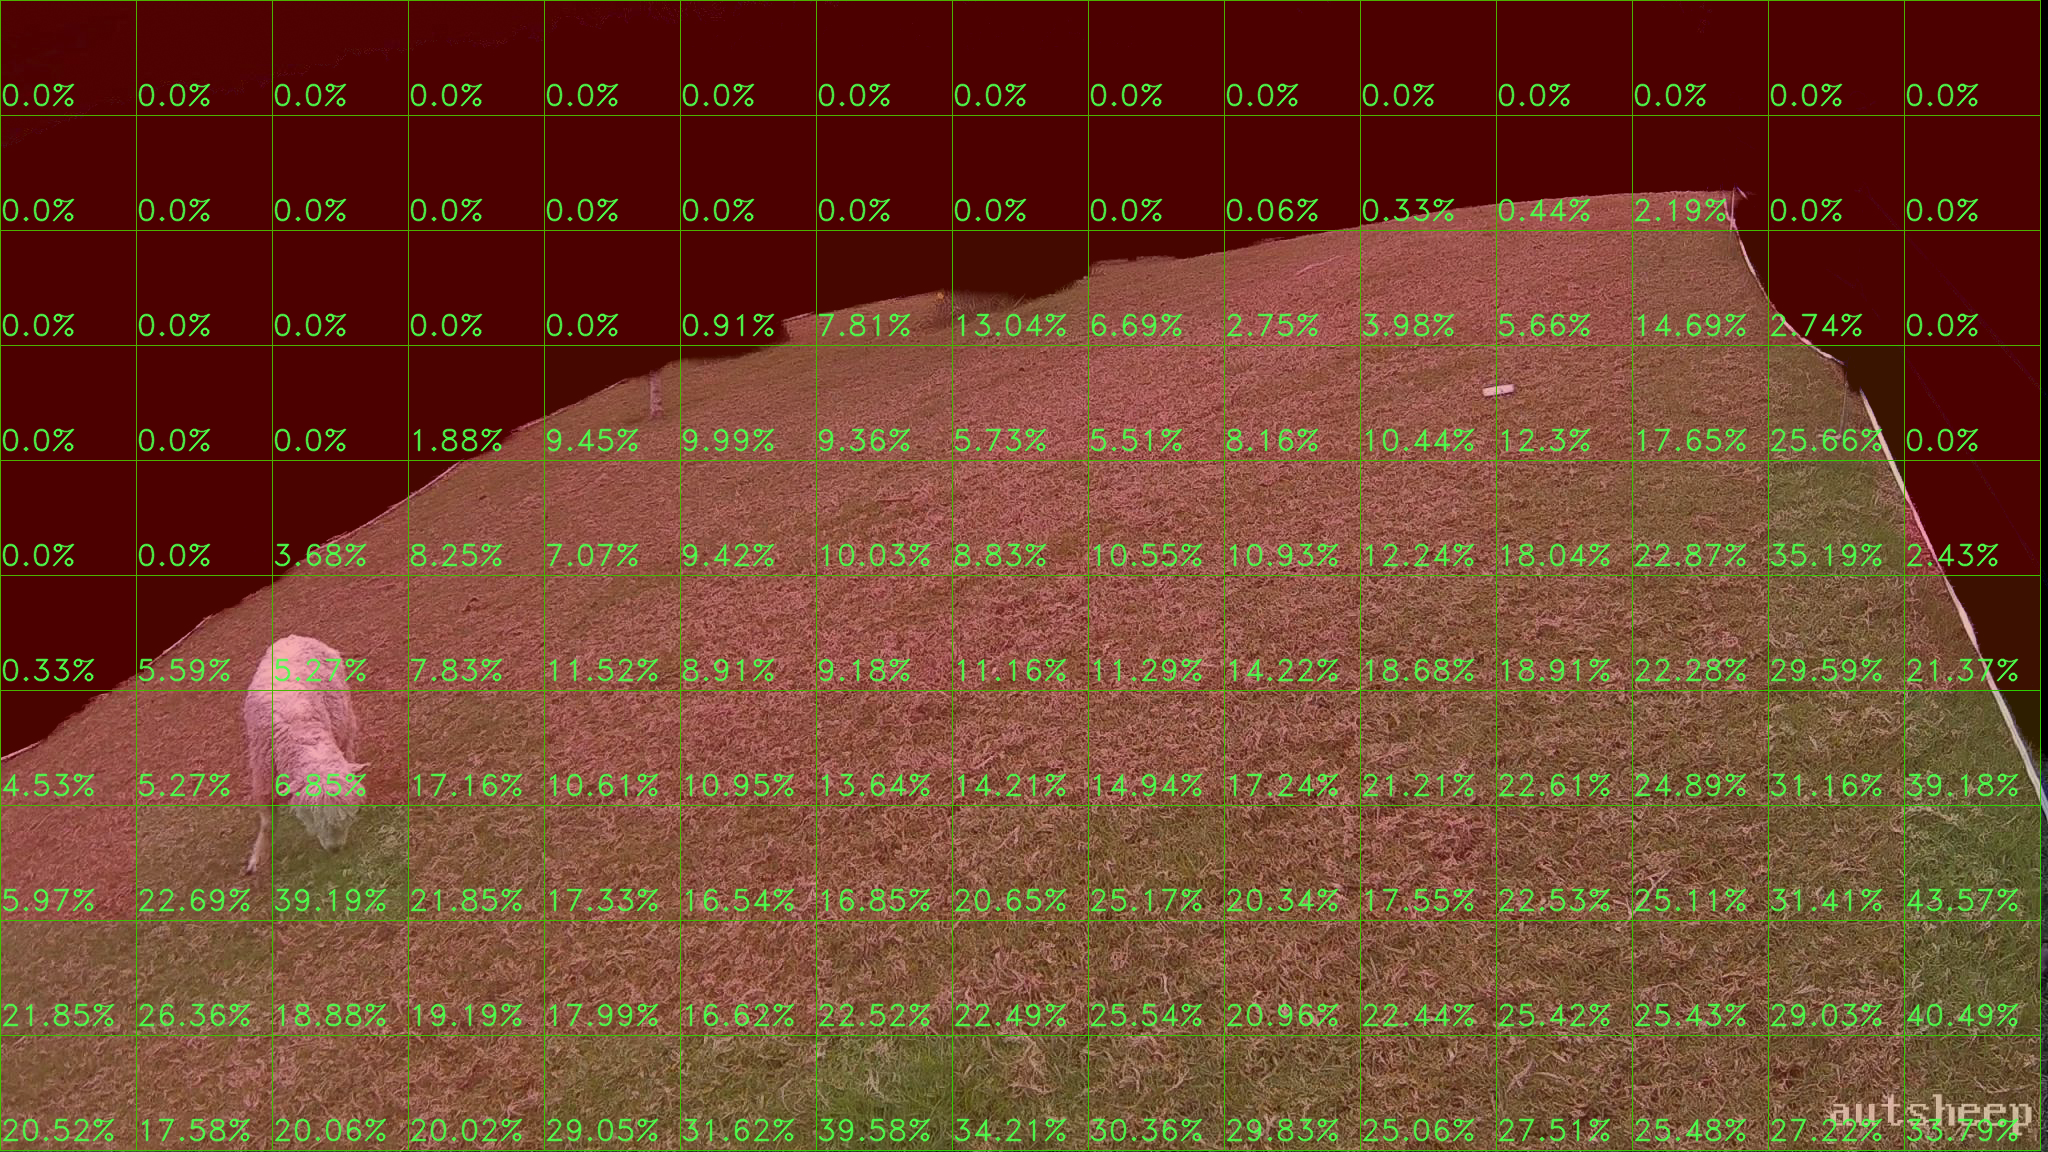

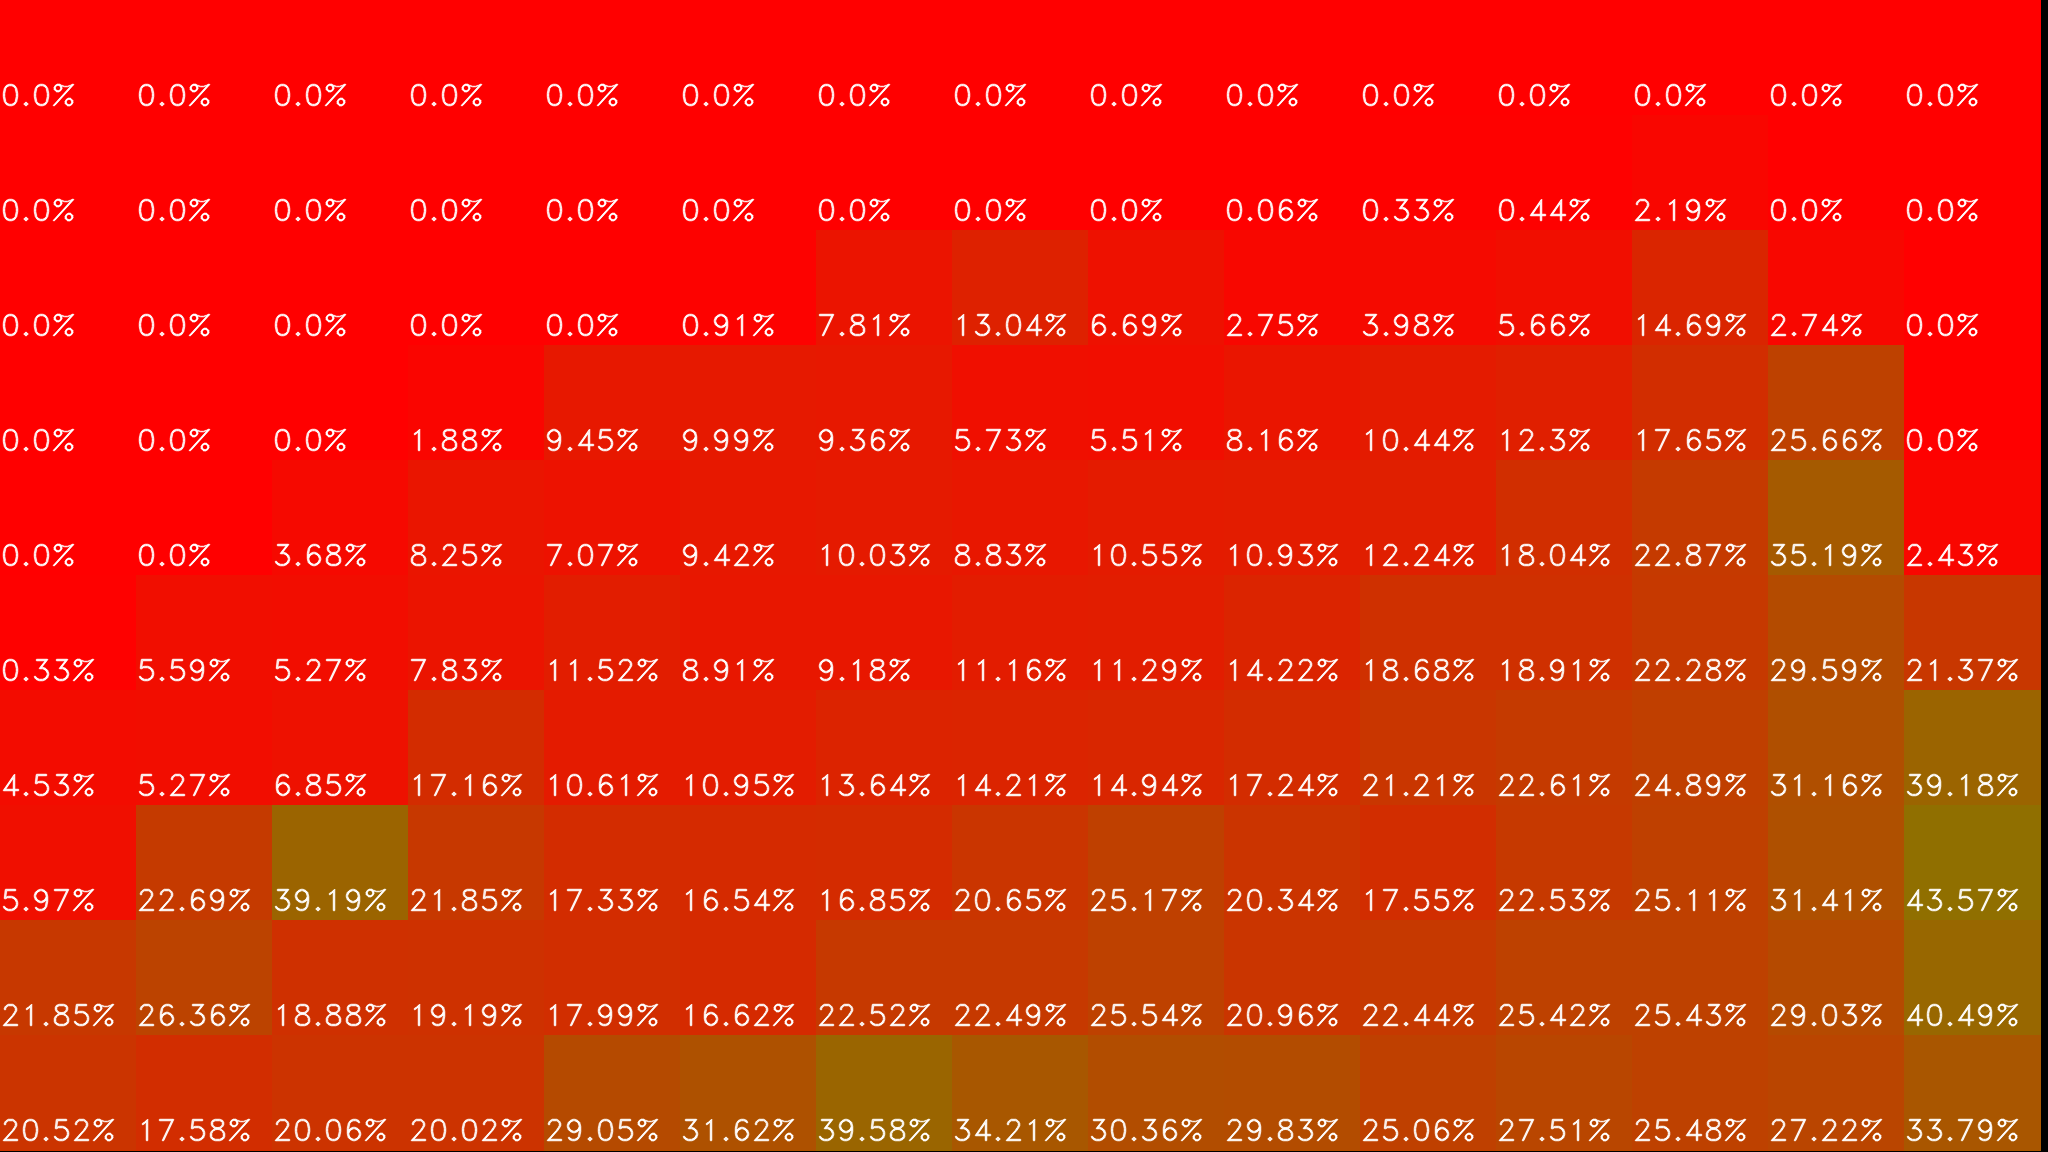

In [14]:
# Initialize a blank image for the heatmap
heatmap = np.zeros_like(image)

def percentage_to_colour(percentage):
    # Ensure the percentage is within the valid range (0 to 100)
    percentage = max(0, min(100, percentage))

    # Map the percentage to a colour gradient from red to green
    red = 1.0 - (percentage / 100.0)
    green = (percentage / 100.0)
    blue = 0.0

    return (blue, green*255, red*255) # Colour in BGR

# Calculate grass percentage and colour each section
for i, percentage in enumerate(grass_percentage):
    row = i // n_cols
    col = i % n_cols

    x1 = col * section_width
    y1 = row * section_height
    x2 = (col + 1) * section_width
    y2 = (row + 1) * section_height

    colour = percentage_to_colour(percentage)
    percentage_string = str(round(percentage,2))+'%'

    cv2.rectangle(heatmap, (x1, y1), (x2, y2), colour, -1)  # -1 fills the rectangle
    cv2.putText(heatmap, percentage_string, (x1,y2-10), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)

# Overlay the heatmap on the original image
overlay = cv2.addWeighted(image, 0.7, heatmap, 0.3, 0)

cv2.imwrite("output/"+image_file_name+"-overlay.png",overlay) # Save overlay
cv2.imwrite("output/"+image_file_name+"-heatmap.png",heatmap) # Save heatmap

cv2_imshow(overlay)  # Display the final overlay
cv2_imshow(heatmap)  # Display the final heatmap